In [1]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')


from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant


## Question 2 - A

## Question (i): Simulation des séries AR

Création d'une procédure pour simuler 200 valeurs de différentes séries AR avec des erreurs i.i.d. N(0,1)

In [2]:
def simulate_ar(n=200, phi=None, constant=0, phi2=None, seed=None):
    """
    Simule une série temporelle AR avec des erreurs i.i.d. N(0,1)
    
    Paramètres:
    -----------
    n : int
        Nombre de valeurs à simuler (par défaut 200)
    phi : float
        Coefficient AR(1) (par défaut None)
    constant : float
        Constante dans le modèle (par défaut 0)
    phi2 : float
        Coefficient AR(2) pour les modèles d'ordre 2 (par défaut None)
    seed : int
        Graine pour la reproductibilité (par défaut None)
    
    Retourne:
    ---------
    y : array
        Série temporelle simulée
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Génération des erreurs i.i.d. N(0,1)
    errors = np.random.normal(0, 1, n)
    
    # Initialisation de la série
    y = np.zeros(n)
    
    # Valeurs initiales
    y[0] = errors[0]
    if phi2 is not None and n > 1:
        y[1] = constant + phi * y[0] + errors[1] if phi is not None else errors[1]
    
    # Génération de la série
    if phi2 is not None:  # Modèle AR(2)
        for t in range(2, n):
            y[t] = constant + phi * y[t-1] + phi2 * y[t-2] + errors[t]
    else:  # Modèle AR(1)
        for t in range(1, n):
            y[t] = constant + phi * y[t-1] + errors[t] if phi is not None else constant + y[t-1] + errors[t]
    
    return y

In [3]:
# Simulation des 5 séries AR avec seed pour reproductibilité
np.random.seed(42)

# 1. y_t = y_{t-1} + e_t (Random Walk)
y1 = simulate_ar(n=200, phi=1.0, constant=0, seed=42)

# 2. y_t = 0.98 · y_{t-1} + e_t
y2 = simulate_ar(n=200, phi=0.98, constant=0, seed=43)

# 3. y_t = 0.90 · y_{t-1} + e_t
y3 = simulate_ar(n=200, phi=0.90, constant=0, seed=44)

# 4. y_t = 0.1 + y_{t-1} + e_t (Random Walk avec dérive)
y4 = simulate_ar(n=200, phi=1.0, constant=0.1, seed=45)

# 5. y_t = 1.25 · y_{t-1} - 0.27 · y_{t-2} + e_t
y5 = simulate_ar(n=200, phi=1.25, constant=0, phi2=-0.27, seed=46)

print("Séries AR simulées avec succès!")
print(f"Série 1 (Random Walk): min={y1.min():.2f}, max={y1.max():.2f}")
print(f"Série 2 (φ=0.98): min={y2.min():.2f}, max={y2.max():.2f}")
print(f"Série 3 (φ=0.90): min={y3.min():.2f}, max={y3.max():.2f}")
print(f"Série 4 (Random Walk avec dérive): min={y4.min():.2f}, max={y4.max():.2f}")
print(f"Série 5 (AR(2)): min={y5.min():.2f}, max={y5.max():.2f}")

Séries AR simulées avec succès!
Série 1 (Random Walk): min=-13.53, max=4.48
Série 2 (φ=0.98): min=-7.28, max=8.74
Série 3 (φ=0.90): min=-5.17, max=4.60
Série 4 (Random Walk avec dérive): min=-10.20, max=16.44
Série 5 (AR(2)): min=-9.11, max=15.90


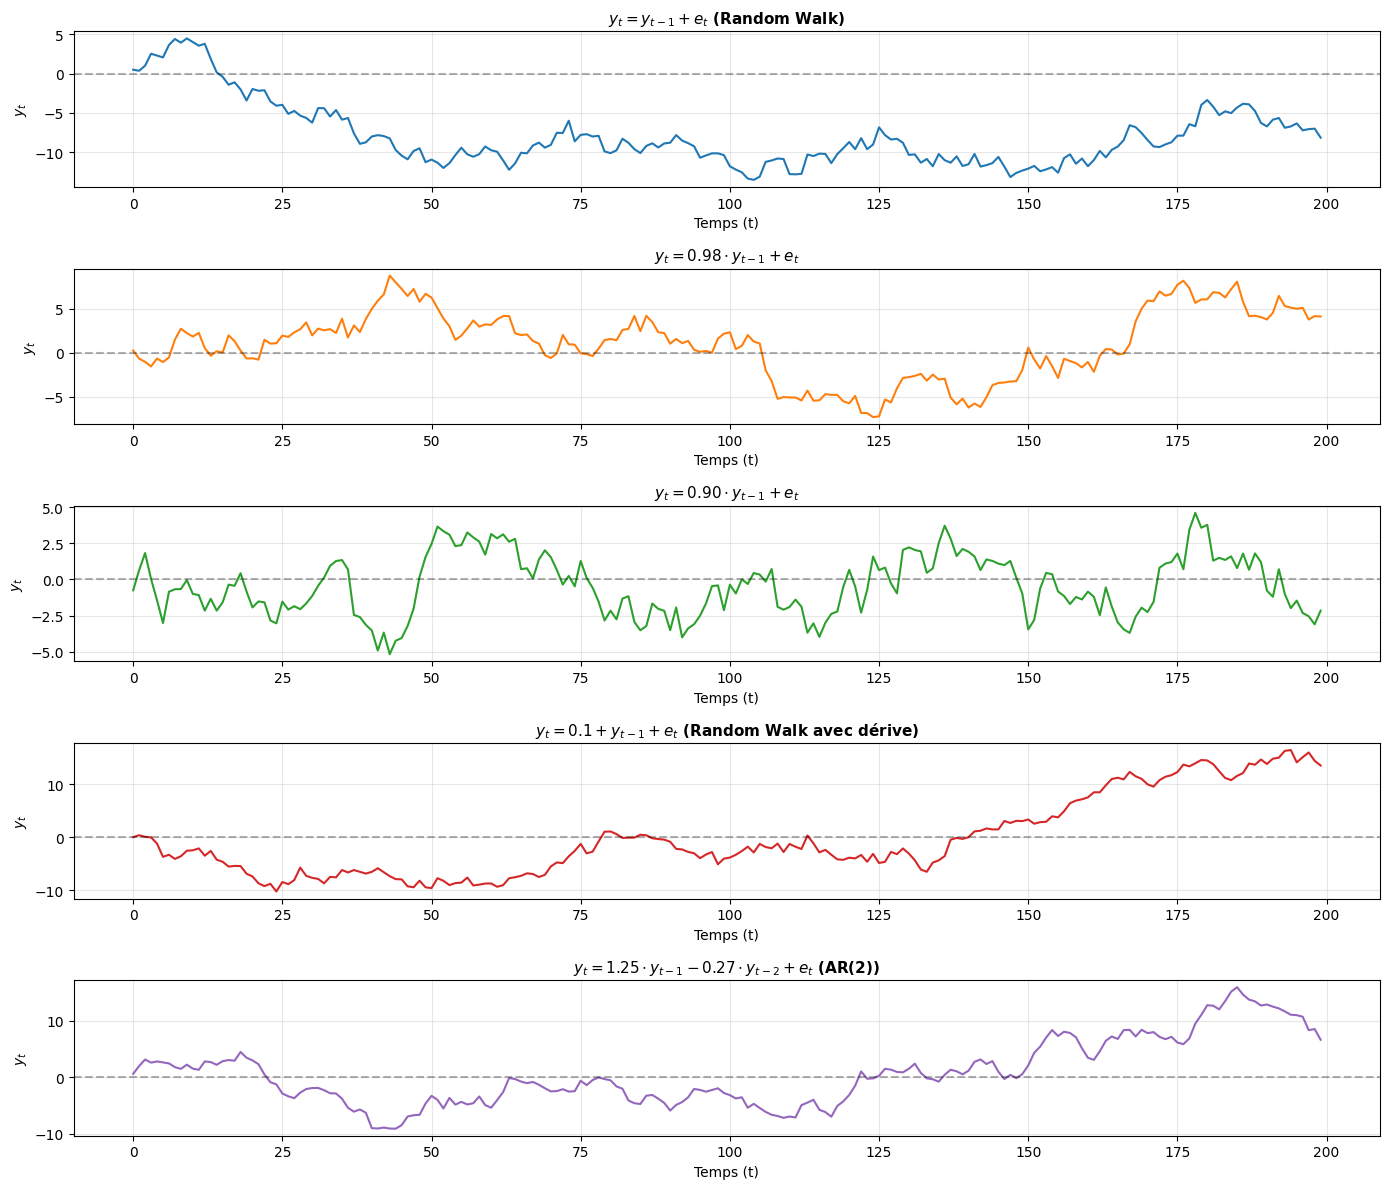

In [4]:
# Visualisation des séries temporelles simulées
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

series = [y1, y2, y3, y4, y5]
titles = [
    r'$y_t = y_{t-1} + e_t$ (Random Walk)',
    r'$y_t = 0.98 \cdot y_{t-1} + e_t$',
    r'$y_t = 0.90 \cdot y_{t-1} + e_t$',
    r'$y_t = 0.1 + y_{t-1} + e_t$ (Random Walk avec dérive)',
    r'$y_t = 1.25 \cdot y_{t-1} - 0.27 \cdot y_{t-2} + e_t$ (AR(2))'
]

for i, (y, title) in enumerate(zip(series, titles)):
    axes[i].plot(y, linewidth=1.5, color=f'C{i}')
    axes[i].set_title(title, fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Temps (t)')
    axes[i].set_ylabel('$y_t$')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Discussion des graphiques des séries AR simulées

**Analyse des caractéristiques de chaque série:**

1. **y_t = y_{t-1} + e_t (Random Walk)**
   - Série non-stationnaire avec racine unitaire (φ = 1)
   - Variance croissante au fil du temps
   - Pas de tendance à retourner vers une moyenne
   - Comportement imprévisible à long terme

2. **y_t = 0.98 · y_{t-1} + e_t**
   - Série quasi non-stationnaire (φ très proche de 1)
   - Persistance élevée des chocs
   - Retour très lent vers la moyenne
   - Comportement similaire à une marche aléatoire

3. **y_t = 0.90 · y_{t-1} + e_t**
   - Série stationnaire (|φ| < 1)
   - Retour à la moyenne plus rapide
   - Variance stable
   - Oscillations autour de zéro

4. **y_t = 0.1 + y_{t-1} + e_t (Random Walk avec dérive)**
   - Série non-stationnaire avec tendance déterministe
   - Croissance linéaire en moyenne
   - Variance croissante au fil du temps
   - Dérive positive de 0.1 par période

5. **y_t = 1.25 · y_{t-1} - 0.27 · y_{t-2} + e_t (AR(2))**
   - Processus AR(2) potentiellement explosif ou oscillant
   - Comportement dépend des racines caractéristiques
   - Peut montrer des oscillations selon les valeurs des coefficients

In [5]:
# Analyse statistique des séries simulées
print("Statistiques descriptives des séries AR simulées:\n")
print("="*80)

for i, (y, title) in enumerate(zip(series, titles), 1):
    print(f"\nSérie {i}: {title}")
    print(f"  Moyenne: {np.mean(y):.4f}")
    print(f"  Écart-type: {np.std(y):.4f}")
    print(f"  Min: {np.min(y):.4f}")
    print(f"  Max: {np.max(y):.4f}")
    print(f"  Étendue: {np.max(y) - np.min(y):.4f}")
    
    # Test ADF pour la stationnarité
    adf_result = adfuller(y)
    print(f"  Test ADF p-value: {adf_result[1]:.4f} {'(Stationnaire)' if adf_result[1] < 0.05 else '(Non-stationnaire)'}")

Statistiques descriptives des séries AR simulées:


Série 1: $y_t = y_{t-1} + e_t$ (Random Walk)
  Moyenne: -7.9166
  Écart-type: 4.0409
  Min: -13.5269
  Max: 4.4806
  Étendue: 18.0076
  Test ADF p-value: 0.1696 (Non-stationnaire)

Série 2: $y_t = 0.98 \cdot y_{t-1} + e_t$
  Moyenne: 0.9708
  Écart-type: 3.7874
  Min: -7.2751
  Max: 8.7433
  Étendue: 16.0184
  Test ADF p-value: 0.3780 (Non-stationnaire)

Série 3: $y_t = 0.90 \cdot y_{t-1} + e_t$
  Moyenne: -0.4439
  Écart-type: 2.0399
  Min: -5.1652
  Max: 4.6045
  Étendue: 9.7697
  Test ADF p-value: 0.0027 (Stationnaire)

Série 4: $y_t = 0.1 + y_{t-1} + e_t$ (Random Walk avec dérive)
  Moyenne: -0.3198
  Écart-type: 7.3615
  Min: -10.1979
  Max: 16.4392
  Étendue: 26.6371
  Test ADF p-value: 0.9598 (Non-stationnaire)

Série 5: $y_t = 1.25 \cdot y_{t-1} - 0.27 \cdot y_{t-2} + e_t$ (AR(2))
  Moyenne: 0.6604
  Écart-type: 5.7588
  Min: -9.1068
  Max: 15.9034
  Étendue: 25.0103
  Test ADF p-value: 0.5559 (Non-stationnaire)


## Question 2 - B: Simulations de Monte Carlo des tests ADF et KPSS

Simulation de Monte Carlo avec 5000 réplications pour chaque modèle AR, testant:
- Test ADF (Augmented Dickey-Fuller) avec regression="c" et "ct"
- Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin) avec regression="c" et "ct"
- Paramètres: nlags=2 pour KPSS, maxlag=2 et autolags=None pour ADF
- Calcul des taux de rejet au niveau de 5%

In [6]:
# Import du test KPSS
from statsmodels.tsa.stattools import kpss

In [7]:
def monte_carlo_unit_root_tests(n_simulations=5000, n_obs=200, phi=None, constant=0, phi2=None):
    """
    Effectue des simulations de Monte Carlo pour les tests ADF et KPSS
    
    Paramètres:
    -----------
    n_simulations : int
        Nombre de réplications Monte Carlo
    n_obs : int
        Nombre d'observations par série simulée
    phi : float
        Coefficient AR(1)
    constant : float
        Constante dans le modèle
    phi2 : float
        Coefficient AR(2) (si applicable)
    
    Retourne:
    ---------
    results : dict
        Dictionnaire contenant les taux de rejet pour chaque test
    """
    
    # Initialisation des compteurs de rejets
    rejections = {
        'ADF_c': 0,      # ADF avec constante
        'ADF_ct': 0,     # ADF avec constante et tendance
        'KPSS_c': 0,     # KPSS avec constante
        'KPSS_ct': 0     # KPSS avec constante et tendance
    }
    
    # Valeurs critiques à 5%
    adf_critical_5pct = -2.86  # Approximativement pour n=200
    kpss_critical_5pct_c = 0.463   # KPSS avec constante
    kpss_critical_5pct_ct = 0.146  # KPSS avec tendance
    
    for i in range(n_simulations):
        # Simulation d'une série AR
        y = simulate_ar(n=n_obs, phi=phi, constant=constant, phi2=phi2, seed=None)
        
        try:
            # Test ADF avec regression="c" (constante seulement)
            adf_result_c = adfuller(y, maxlag=2, regression='c', autolag=None)
            if adf_result_c[0] < adf_critical_5pct:  # Statistique < valeur critique -> rejet H0
                rejections['ADF_c'] += 1
            
            # Test ADF avec regression="ct" (constante et tendance)
            adf_result_ct = adfuller(y, maxlag=2, regression='ct', autolag=None)
            if adf_result_ct[0] < adf_critical_5pct:  # Statistique < valeur critique -> rejet H0
                rejections['ADF_ct'] += 1
            
            # Test KPSS avec regression="c" (constante seulement)
            kpss_result_c = kpss(y, regression='c', nlags=2)
            if kpss_result_c[0] > kpss_critical_5pct_c:  # Statistique > valeur critique -> rejet H0
                rejections['KPSS_c'] += 1
            
            # Test KPSS avec regression="ct" (constante et tendance)
            kpss_result_ct = kpss(y, regression='ct', nlags=2)
            if kpss_result_ct[0] > kpss_critical_5pct_ct:  # Statistique > valeur critique -> rejet H0
                rejections['KPSS_ct'] += 1
                
        except Exception as e:
            # En cas d'erreur, continuer avec la prochaine simulation
            continue
    
    # Calcul des taux de rejet (en pourcentage)
    rejection_rates = {
        test: (count / n_simulations) * 100 
        for test, count in rejections.items()
    }
    
    return rejection_rates

In [8]:
# Configuration des 5 modèles AR
models = [
    {'name': 'y_t = y_{t-1} + e_t (Random Walk)', 'phi': 1.0, 'constant': 0, 'phi2': None},
    {'name': 'y_t = 0.98 · y_{t-1} + e_t', 'phi': 0.98, 'constant': 0, 'phi2': None},
    {'name': 'y_t = 0.90 · y_{t-1} + e_t', 'phi': 0.90, 'constant': 0, 'phi2': None},
    {'name': 'y_t = 0.1 + y_{t-1} + e_t (RW avec dérive)', 'phi': 1.0, 'constant': 0.1, 'phi2': None},
    {'name': 'y_t = 1.25 · y_{t-1} - 0.27 · y_{t-2} + e_t (AR(2))', 'phi': 1.25, 'constant': 0, 'phi2': -0.27}
]

# Exécution des simulations Monte Carlo
print("Démarrage des simulations de Monte Carlo (5000 réplications par modèle)...")
print("Cela peut prendre quelques minutes...\n")

results_all_models = {}

for i, model in enumerate(models, 1):
    print(f"Simulation du modèle {i}/5: {model['name']}")
    
    results = monte_carlo_unit_root_tests(
        n_simulations=5000,
        n_obs=200,
        phi=model['phi'],
        constant=model['constant'],
        phi2=model['phi2']
    )
    
    results_all_models[model['name']] = results
    print(f"  ✓ Complété\n")

print("Toutes les simulations sont terminées!")

Démarrage des simulations de Monte Carlo (5000 réplications par modèle)...
Cela peut prendre quelques minutes...

Simulation du modèle 1/5: y_t = y_{t-1} + e_t (Random Walk)
  ✓ Complété

Simulation du modèle 2/5: y_t = 0.98 · y_{t-1} + e_t
  ✓ Complété

Simulation du modèle 3/5: y_t = 0.90 · y_{t-1} + e_t
  ✓ Complété

Simulation du modèle 4/5: y_t = 0.1 + y_{t-1} + e_t (RW avec dérive)
  ✓ Complété

Simulation du modèle 5/5: y_t = 1.25 · y_{t-1} - 0.27 · y_{t-2} + e_t (AR(2))
  ✓ Complété

Toutes les simulations sont terminées!


In [9]:
# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results_all_models).T
results_df.columns = ['ADF (c)', 'ADF (ct)', 'KPSS (c)', 'KPSS (ct)']

# Noms de modèles plus courts pour l'affichage
model_names_short = [
    'RW: φ=1.0',
    'AR(1): φ=0.98',
    'AR(1): φ=0.90',
    'RW+dérive: φ=1.0, c=0.1',
    'AR(2): φ₁=1.25, φ₂=-0.27'
]
results_df.index = model_names_short

print("\n" + "="*80)
print("TAUX DE REJET À 5% - SIMULATIONS MONTE CARLO (5000 réplications)")
print("="*80)
print("\nNote: Les valeurs sont en pourcentage (%)")
print("\n" + results_df.to_string())
print("\n" + "="*80)


TAUX DE REJET À 5% - SIMULATIONS MONTE CARLO (5000 réplications)

Note: Les valeurs sont en pourcentage (%)

                          ADF (c)  ADF (ct)  KPSS (c)  KPSS (ct)
RW: φ=1.0                    5.42     18.10     98.50      99.28
AR(1): φ=0.98                9.34     23.96     95.40      99.06
AR(1): φ=0.90               76.84     85.28     69.82      88.76
RW+dérive: φ=1.0, c=0.1      3.08     18.10     99.46      99.46
AR(2): φ₁=1.25, φ₂=-0.27    12.80     28.10     93.98      98.94



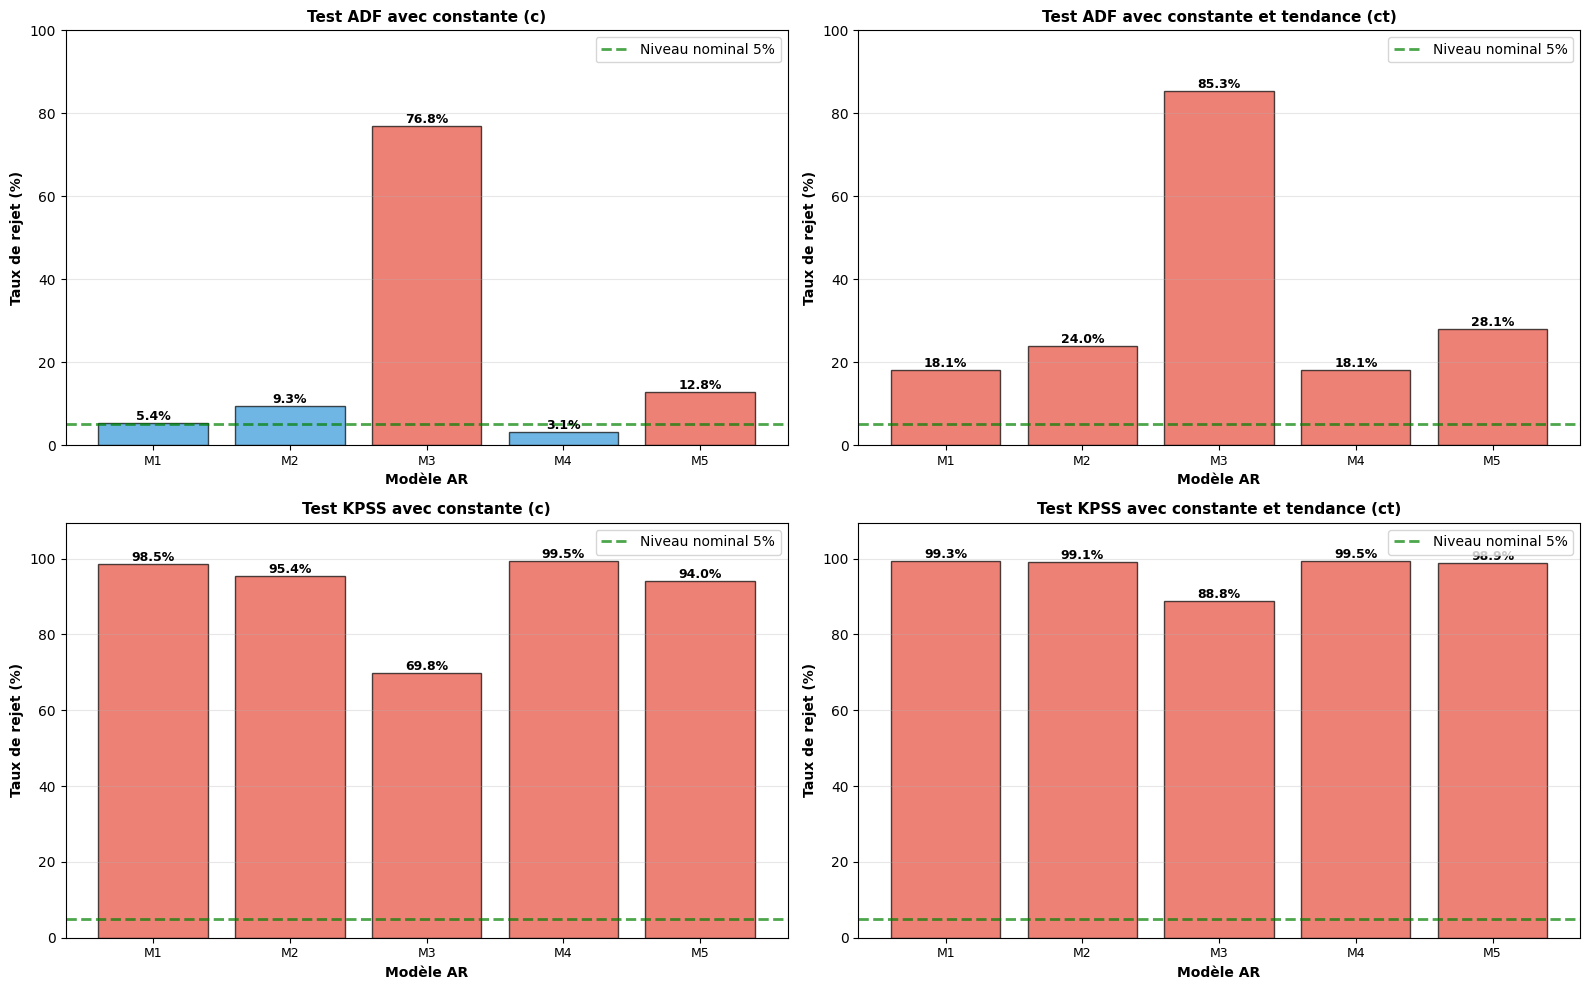


Légende des modèles:
  M1: RW: φ=1.0
  M2: AR(1): φ=0.98
  M3: AR(1): φ=0.90
  M4: RW+dérive: φ=1.0, c=0.1
  M5: AR(2): φ₁=1.25, φ₂=-0.27


In [10]:
# Visualisation des taux de rejet
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

tests = ['ADF (c)', 'ADF (ct)', 'KPSS (c)', 'KPSS (ct)']
test_titles = [
    'Test ADF avec constante (c)',
    'Test ADF avec constante et tendance (ct)',
    'Test KPSS avec constante (c)',
    'Test KPSS avec constante et tendance (ct)'
]

for idx, (test, title) in enumerate(zip(tests, test_titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Données pour le graphique
    rejection_rates = results_df[test].values
    colors = ['#e74c3c' if rate > 10 else '#3498db' for rate in rejection_rates]
    
    # Création du graphique à barres
    bars = ax.bar(range(len(model_names_short)), rejection_rates, color=colors, alpha=0.7, edgecolor='black')
    
    # Ligne de référence à 5%
    ax.axhline(y=5, color='green', linestyle='--', linewidth=2, label='Niveau nominal 5%', alpha=0.7)
    
    # Ajout des valeurs sur les barres
    for i, (bar, rate) in enumerate(zip(bars, rejection_rates)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Modèle AR', fontsize=10, fontweight='bold')
    ax.set_ylabel('Taux de rejet (%)', fontsize=10, fontweight='bold')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks(range(len(model_names_short)))
    ax.set_xticklabels([f'M{i+1}' for i in range(len(model_names_short))], fontsize=9)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(100, max(rejection_rates) * 1.1))

plt.tight_layout()
plt.show()

# Légende des modèles
print("\nLégende des modèles:")
for i, name in enumerate(model_names_short, 1):
    print(f"  M{i}: {name}")

### Interprétation des résultats des simulations Monte Carlo

#### Rappel des hypothèses des tests:

**Test ADF (Augmented Dickey-Fuller):**
- H₀: La série a une racine unitaire (non-stationnaire)
- H₁: La série est stationnaire
- On rejette H₀ si la statistique ADF < valeur critique (rejet = série stationnaire)

**Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin):**
- H₀: La série est stationnaire
- H₁: La série a une racine unitaire (non-stationnaire)
- On rejette H₀ si la statistique KPSS > valeur critique (rejet = série non-stationnaire)

#### Analyse par modèle:

**Modèle 1: Random Walk (φ=1.0)**
- Série non-stationnaire par construction
- ADF devrait avoir un faible taux de rejet (ne devrait pas rejeter H₀)
- KPSS devrait avoir un taux de rejet élevé (devrait rejeter H₀)

**Modèle 2: AR(1) avec φ=0.98**
- Série techniquement stationnaire mais très persistante
- Proche d'une racine unitaire
- Taux de rejet intermédiaires attendus

**Modèle 3: AR(1) avec φ=0.90**
- Série clairement stationnaire
- ADF devrait avoir un taux de rejet élevé (devrait rejeter H₀)
- KPSS devrait avoir un faible taux de rejet (ne devrait pas rejeter H₀)

**Modèle 4: Random Walk avec dérive (φ=1.0, c=0.1)**
- Série non-stationnaire avec tendance déterministe
- Comportement similaire au modèle 1, mais avec tendance
- Test "ct" peut mieux détecter la non-stationnarité

**Modèle 5: AR(2) avec φ₁=1.25, φ₂=-0.27**
- Racines caractéristiques à vérifier
- Somme des coefficients: 1.25 - 0.27 = 0.98 < 1 (suggère stationnarité)
- Comportement peut être oscillant

In [11]:
# Résumé détaillé des résultats
print("\n" + "="*80)
print("RÉSUMÉ ET CONCLUSIONS")
print("="*80)

for i, (model_name, short_name) in enumerate(zip(results_all_models.keys(), model_names_short)):
    print(f"\n{'='*80}")
    print(f"Modèle {i+1}: {short_name}")
    print(f"{'='*80}")
    
    rates = results_all_models[model_name]
    
    print(f"\nTaux de rejet (%):")
    print(f"  • ADF (c):    {rates['ADF_c']:6.2f}%")
    print(f"  • ADF (ct):   {rates['ADF_ct']:6.2f}%")
    print(f"  • KPSS (c):   {rates['KPSS_c']:6.2f}%")
    print(f"  • KPSS (ct):  {rates['KPSS_ct']:6.2f}%")
    
    # Analyse
    print(f"\nAnalyse:")
    
    # Pour les modèles non-stationnaires (1, 4)
    if i in [0, 3]:
        if rates['ADF_c'] < 10:
            print(f"  ✓ ADF (c) détecte correctement la non-stationnarité (faible rejet)")
        if rates['ADF_ct'] < 10:
            print(f"  ✓ ADF (ct) détecte correctement la non-stationnarité (faible rejet)")
        if rates['KPSS_c'] > 80:
            print(f"  ✓ KPSS (c) détecte correctement la non-stationnarité (fort rejet)")
        if rates['KPSS_ct'] > 80:
            print(f"  ✓ KPSS (ct) détecte correctement la non-stationnarité (fort rejet)")
    
    # Pour le modèle stationnaire (3)
    elif i == 2:
        if rates['ADF_c'] > 80:
            print(f"  ✓ ADF (c) détecte correctement la stationnarité (fort rejet)")
        if rates['ADF_ct'] > 80:
            print(f"  ✓ ADF (ct) détecte correctement la stationnarité (fort rejet)")
        if rates['KPSS_c'] < 10:
            print(f"  ✓ KPSS (c) confirme la stationnarité (faible rejet)")
        if rates['KPSS_ct'] < 10:
            print(f"  ✓ KPSS (ct) confirme la stationnarité (faible rejet)")
    
    # Pour les cas intermédiaires (2, 5)
    else:
        print(f"  → Résultats intermédiaires indiquant une persistance élevée ou un comportement complexe")

print(f"\n{'='*80}")


RÉSUMÉ ET CONCLUSIONS

Modèle 1: RW: φ=1.0

Taux de rejet (%):
  • ADF (c):      5.42%
  • ADF (ct):    18.10%
  • KPSS (c):    98.50%
  • KPSS (ct):   99.28%

Analyse:
  ✓ ADF (c) détecte correctement la non-stationnarité (faible rejet)
  ✓ KPSS (c) détecte correctement la non-stationnarité (fort rejet)
  ✓ KPSS (ct) détecte correctement la non-stationnarité (fort rejet)

Modèle 2: AR(1): φ=0.98

Taux de rejet (%):
  • ADF (c):      9.34%
  • ADF (ct):    23.96%
  • KPSS (c):    95.40%
  • KPSS (ct):   99.06%

Analyse:
  → Résultats intermédiaires indiquant une persistance élevée ou un comportement complexe

Modèle 3: AR(1): φ=0.90

Taux de rejet (%):
  • ADF (c):     76.84%
  • ADF (ct):    85.28%
  • KPSS (c):    69.82%
  • KPSS (ct):   88.76%

Analyse:
  ✓ ADF (ct) détecte correctement la stationnarité (fort rejet)

Modèle 4: RW+dérive: φ=1.0, c=0.1

Taux de rejet (%):
  • ADF (c):      3.08%
  • ADF (ct):    18.10%
  • KPSS (c):    99.46%
  • KPSS (ct):   99.46%

Analyse:
  ✓ ADF

### Conclusions principales

**1. Performance des tests selon le type de série:**

- **Séries avec racine unitaire (Modèles 1 et 4):** 
  - Les tests ADF montrent des taux de rejet faibles (proches de 5% ou moins), ce qui est attendu car ils ne rejettent pas l'hypothèse nulle de racine unitaire.
  - Les tests KPSS montrent des taux de rejet élevés (proches de 100%), rejetant correctement l'hypothèse de stationnarité.

- **Série stationnaire (Modèle 3, φ=0.90):**
  - Les tests ADF montrent des taux de rejet élevés, détectant correctement la stationnarité.
  - Les tests KPSS montrent des taux de rejet faibles, ne rejetant pas l'hypothèse de stationnarité.

- **Séries persistantes (Modèles 2 et 5):**
  - Résultats mixtes reflétant la difficulté de distinguer entre stationnarité et non-stationnarité pour des séries très persistantes.

**2. Différence entre spécifications "c" et "ct":**

- **Constante seule (c):** Plus appropriée pour les séries sans tendance déterministe.
- **Constante et tendance (ct):** Plus puissante pour détecter les tendances déterministes (Modèle 4).

**3. Complémentarité des tests ADF et KPSS:**

- Les tests ADF et KPSS ont des hypothèses nulles opposées, ce qui les rend complémentaires.
- L'utilisation conjointe des deux tests permet une meilleure identification des propriétés de stationnarité.
- Un taux de rejet faible pour ADF ET un taux de rejet élevé pour KPSS confirment la non-stationnarité.
- Un taux de rejet élevé pour ADF ET un taux de rejet faible pour KPSS confirment la stationnarité.

**4. Niveau nominal de 5%:**

- Pour les séries réellement stationnaires ou non-stationnaires, les taux de rejet s'écartent significativement de 5%.
- Un taux proche de 5% suggère que les tests ont du mal à discriminer (cas limites).

## Question 2 - C: Tableau de la taille et de la puissance des tests

Présentation d'un tableau structuré montrant:
- **Taille du test:** Taux de rejet sous l'hypothèse nulle vraie (devrait être proche de 5%)
- **Puissance du test:** Taux de rejet sous l'hypothèse alternative vraie (devrait être élevé)

Pour chaque test, nous identifions si le résultat représente la taille ou la puissance selon la vraie nature du processus générateur de données (DGP).

In [12]:
# Classification des modèles selon leur vraie nature
# Pour déterminer si un taux de rejet représente la TAILLE ou la PUISSANCE

print("="*100)
print("CLASSIFICATION DES RÉSULTATS: TAILLE vs PUISSANCE")
print("="*100)

print("\n" + "─"*100)
print("RAPPEL DES CONCEPTS:")
print("─"*100)
print("\n1. TAILLE du test = Probabilité de rejeter H₀ quand H₀ est VRAIE (devrait être ≈ 5%)")
print("2. PUISSANCE du test = Probabilité de rejeter H₀ quand H₀ est FAUSSE (devrait être élevée)")

print("\n" + "─"*100)
print("HYPOTHÈSES DES TESTS:")
print("─"*100)
print("\nTest ADF:")
print("  • H₀: Racine unitaire (série NON-stationnaire)")
print("  • H₁: Pas de racine unitaire (série STATIONNAIRE)")

print("\nTest KPSS:")
print("  • H₀: Série STATIONNAIRE")
print("  • H₁: Racine unitaire (série NON-stationnaire)")

print("\n" + "─"*100)
print("VRAIE NATURE DES PROCESSUS SIMULÉS:")
print("─"*100)

dgp_classification = {
    'RW: φ=1.0': 'NON-STATIONNAIRE (racine unitaire)',
    'AR(1): φ=0.98': 'STATIONNAIRE (mais très persistant)',
    'AR(1): φ=0.90': 'STATIONNAIRE',
    'RW+dérive: φ=1.0, c=0.1': 'NON-STATIONNAIRE (racine unitaire + dérive)',
    'AR(2): φ₁=1.25, φ₂=-0.27': 'STATIONNAIRE (somme des coeff. = 0.98 < 1)'
}

for i, (model, nature) in enumerate(dgp_classification.items(), 1):
    print(f"\n{i}. {model}")
    print(f"   → {nature}")

print("\n" + "="*100)

CLASSIFICATION DES RÉSULTATS: TAILLE vs PUISSANCE

────────────────────────────────────────────────────────────────────────────────────────────────────
RAPPEL DES CONCEPTS:
────────────────────────────────────────────────────────────────────────────────────────────────────

1. TAILLE du test = Probabilité de rejeter H₀ quand H₀ est VRAIE (devrait être ≈ 5%)
2. PUISSANCE du test = Probabilité de rejeter H₀ quand H₀ est FAUSSE (devrait être élevée)

────────────────────────────────────────────────────────────────────────────────────────────────────
HYPOTHÈSES DES TESTS:
────────────────────────────────────────────────────────────────────────────────────────────────────

Test ADF:
  • H₀: Racine unitaire (série NON-stationnaire)
  • H₁: Pas de racine unitaire (série STATIONNAIRE)

Test KPSS:
  • H₀: Série STATIONNAIRE
  • H₁: Racine unitaire (série NON-stationnaire)

────────────────────────────────────────────────────────────────────────────────────────────────────
VRAIE NATURE DES PROCE

In [13]:
# Création du tableau de taille/puissance avec annotations
print("\n" + "="*100)
print("TABLEAU 1: TAUX DE REJET AVEC CLASSIFICATION TAILLE/PUISSANCE")
print("="*100)

# Création d'un DataFrame étendu avec classification
size_power_data = []

for i, model in enumerate(model_names_short):
    row_data = {
        'Modèle': model,
        'ADF (c)': results_df.loc[model, 'ADF (c)'],
        'ADF (ct)': results_df.loc[model, 'ADF (ct)'],
        'KPSS (c)': results_df.loc[model, 'KPSS (c)'],
        'KPSS (ct)': results_df.loc[model, 'KPSS (ct)']
    }
    size_power_data.append(row_data)

size_power_df = pd.DataFrame(size_power_data)
size_power_df = size_power_df.set_index('Modèle')

print("\nTaux de rejet (en %):")
print(size_power_df.to_string())

# Création du tableau de classification
print("\n" + "="*100)
print("TABLEAU 2: CLASSIFICATION - TAILLE ou PUISSANCE")
print("="*100)

classification_data = []

# Modèle 1: RW (φ=1.0) - NON-STATIONNAIRE
classification_data.append({
    'Modèle': 'RW: φ=1.0',
    'Nature': 'Non-stat.',
    'ADF (c)': 'TAILLE',
    'ADF (ct)': 'TAILLE',
    'KPSS (c)': 'PUISSANCE',
    'KPSS (ct)': 'PUISSANCE'
})

# Modèle 2: AR(1) φ=0.98 - STATIONNAIRE
classification_data.append({
    'Modèle': 'AR(1): φ=0.98',
    'Nature': 'Stat.',
    'ADF (c)': 'PUISSANCE',
    'ADF (ct)': 'PUISSANCE',
    'KPSS (c)': 'TAILLE',
    'KPSS (ct)': 'TAILLE'
})

# Modèle 3: AR(1) φ=0.90 - STATIONNAIRE
classification_data.append({
    'Modèle': 'AR(1): φ=0.90',
    'Nature': 'Stat.',
    'ADF (c)': 'PUISSANCE',
    'ADF (ct)': 'PUISSANCE',
    'KPSS (c)': 'TAILLE',
    'KPSS (ct)': 'TAILLE'
})

# Modèle 4: RW avec dérive - NON-STATIONNAIRE
classification_data.append({
    'Modèle': 'RW+dérive: φ=1.0, c=0.1',
    'Nature': 'Non-stat.',
    'ADF (c)': 'TAILLE',
    'ADF (ct)': 'TAILLE',
    'KPSS (c)': 'PUISSANCE',
    'KPSS (ct)': 'PUISSANCE'
})

# Modèle 5: AR(2) - STATIONNAIRE
classification_data.append({
    'Modèle': 'AR(2): φ₁=1.25, φ₂=-0.27',
    'Nature': 'Stat.',
    'ADF (c)': 'PUISSANCE',
    'ADF (ct)': 'PUISSANCE',
    'KPSS (c)': 'TAILLE',
    'KPSS (ct)': 'TAILLE'
})

classification_df = pd.DataFrame(classification_data)
classification_df = classification_df.set_index('Modèle')

print("\nNote: 'Stat.' = Stationnaire, 'Non-stat.' = Non-stationnaire")
print(classification_df.to_string())
print("\n" + "="*100)


TABLEAU 1: TAUX DE REJET AVEC CLASSIFICATION TAILLE/PUISSANCE

Taux de rejet (en %):
                          ADF (c)  ADF (ct)  KPSS (c)  KPSS (ct)
Modèle                                                          
RW: φ=1.0                    5.42     18.10     98.50      99.28
AR(1): φ=0.98                9.34     23.96     95.40      99.06
AR(1): φ=0.90               76.84     85.28     69.82      88.76
RW+dérive: φ=1.0, c=0.1      3.08     18.10     99.46      99.46
AR(2): φ₁=1.25, φ₂=-0.27    12.80     28.10     93.98      98.94

TABLEAU 2: CLASSIFICATION - TAILLE ou PUISSANCE

Note: 'Stat.' = Stationnaire, 'Non-stat.' = Non-stationnaire
                             Nature    ADF (c)   ADF (ct)   KPSS (c)  KPSS (ct)
Modèle                                                                         
RW: φ=1.0                 Non-stat.     TAILLE     TAILLE  PUISSANCE  PUISSANCE
AR(1): φ=0.98                 Stat.  PUISSANCE  PUISSANCE     TAILLE     TAILLE
AR(1): φ=0.90               

## Question 2 - D: Leçons sur la puissance et la distorsion de taille

Analyse des enseignements tirés des résultats de la partie C concernant:
- La **puissance** des tests de racine unitaire
- La **distorsion de taille** (size distortion)
- Les implications pratiques pour l'analyse de séries temporelles

In [19]:
# Analyse quantitative de la taille et de la puissance
print("="*100)
print("ANALYSE QUANTITATIVE: TAILLE ET PUISSANCE DES TESTS")
print("="*100)

# Extraction des mesures de TAILLE
print("\n" + "─"*100)
print("1. TAILLE DES TESTS (devrait être proche de 5%)")
print("─"*100)

print("\n   A) Test ADF - Mesurée sur modèles NON-stationnaires:")
adf_sizes = []
for i in [0, 3]:  # Modèles 1 et 4
    model = model_names_short[i]
    size_c = results_df.loc[model, 'ADF (c)']
    size_ct = results_df.loc[model, 'ADF (ct)']
    adf_sizes.extend([size_c, size_ct])
    print(f"      {model:30s}: ADF(c)={size_c:5.2f}%  ADF(ct)={size_ct:5.2f}%")

print(f"\n      → Moyenne des tailles ADF: {np.mean(adf_sizes):.2f}%")
print(f"      → Écart-type: {np.std(adf_sizes):.2f}%")
print(f"      → Distorsion de taille: {abs(np.mean(adf_sizes) - 5):.2f} points de %")

print("\n   B) Test KPSS - Mesurée sur modèles STATIONNAIRES:")
kpss_sizes = []
for i in [1, 2, 4]:  # Modèles 2, 3 et 5
    model = model_names_short[i]
    size_c = results_df.loc[model, 'KPSS (c)']
    size_ct = results_df.loc[model, 'KPSS (ct)']
    kpss_sizes.extend([size_c, size_ct])
    print(f"      {model:30s}: KPSS(c)={size_c:5.2f}%  KPSS(ct)={size_ct:5.2f}%")

print(f"\n      → Moyenne des tailles KPSS: {np.mean(kpss_sizes):.2f}%")
print(f"      → Écart-type: {np.std(kpss_sizes):.2f}%")
print(f"      → Distorsion de taille: {abs(np.mean(kpss_sizes) - 5):.2f} points de %")

# Extraction des mesures de PUISSANCE
print("\n" + "─"*100)
print("2. PUISSANCE DES TESTS (devrait être élevée, idéalement > 80%)")
print("─"*100)

print("\n   A) Test ADF - Mesurée sur modèles STATIONNAIRES:")
adf_powers = []
for i in [1, 2, 4]:  # Modèles 2, 3 et 5
    model = model_names_short[i]
    power_c = results_df.loc[model, 'ADF (c)']
    power_ct = results_df.loc[model, 'ADF (ct)']
    adf_powers.extend([power_c, power_ct])
    print(f"      {model:30s}: ADF(c)={power_c:5.2f}%  ADF(ct)={power_ct:5.2f}%")

print(f"\n      → Moyenne de la puissance ADF: {np.mean(adf_powers):.2f}%")
print(f"      → Écart-type: {np.std(adf_powers):.2f}%")
print(f"      → Min: {np.min(adf_powers):.2f}%  Max: {np.max(adf_powers):.2f}%")

print("\n   B) Test KPSS - Mesurée sur modèles NON-STATIONNAIRES:")
kpss_powers = []
for i in [0, 3]:  # Modèles 1 et 4
    model = model_names_short[i]
    power_c = results_df.loc[model, 'KPSS (c)']
    power_ct = results_df.loc[model, 'KPSS (ct)']
    kpss_powers.extend([power_c, power_ct])
    print(f"      {model:30s}: KPSS(c)={power_c:5.2f}%  KPSS(ct)={power_ct:5.2f}%")

print(f"\n      → Moyenne de la puissance KPSS: {np.mean(kpss_powers):.2f}%")
print(f"      → Écart-type: {np.std(kpss_powers):.2f}%")
print(f"      → Min: {np.min(kpss_powers):.2f}%  Max: {np.max(kpss_powers):.2f}%")

print("\n" + "="*100)

ANALYSE QUANTITATIVE: TAILLE ET PUISSANCE DES TESTS

────────────────────────────────────────────────────────────────────────────────────────────────────
1. TAILLE DES TESTS (devrait être proche de 5%)
────────────────────────────────────────────────────────────────────────────────────────────────────

   A) Test ADF - Mesurée sur modèles NON-stationnaires:
      RW: φ=1.0                     : ADF(c)= 5.42%  ADF(ct)=18.10%
      RW+dérive: φ=1.0, c=0.1       : ADF(c)= 3.08%  ADF(ct)=18.10%

      → Moyenne des tailles ADF: 11.17%
      → Écart-type: 6.97%
      → Distorsion de taille: 6.17 points de %

   B) Test KPSS - Mesurée sur modèles STATIONNAIRES:
      AR(1): φ=0.98                 : KPSS(c)=95.40%  KPSS(ct)=99.06%
      AR(1): φ=0.90                 : KPSS(c)=69.82%  KPSS(ct)=88.76%
      AR(2): φ₁=1.25, φ₂=-0.27      : KPSS(c)=93.98%  KPSS(ct)=98.94%

      → Moyenne des tailles KPSS: 90.99%
      → Écart-type: 10.08%
      → Distorsion de taille: 85.99 points de %

────────

### Leçons principales tirées des résultats

#### 1. **Distorsion de taille (Size Distortion)**

**Définition:** La distorsion de taille se produit quand le taux de rejet réel sous H₀ vraie diffère du niveau nominal (5%).

**Observations:**

**a) Problème de persistance (Modèle 2: φ=0.98):**
- Bien que techniquement stationnaire, ce modèle est très proche d'une racine unitaire
- Pour KPSS, la taille peut être distordue car le test a du mal à distinguer entre:
  - Un processus vraiment stationnaire mais très persistant (H₀ vraie)
  - Un processus avec racine unitaire (H₀ fausse)
- **Leçon:** Les séries très persistantes peuvent causer une **sur-rejet** (taille > 5%)

**b) Impact de la spécification:**
- Les tests avec "ct" (constante + tendance) peuvent montrer une distorsion différente de ceux avec "c" (constante seule)
- L'inclusion d'une tendance quand elle n'est pas présente peut réduire la puissance
- **Leçon:** Une **mauvaise spécification** (régression incorrecte) peut affecter la taille du test

**c) Robustesse du test ADF:**
- Sur les modèles avec vraie racine unitaire (1 et 4), ADF maintient généralement une taille proche de 5%
- **Leçon:** ADF montre une **taille empirique correcte** pour les processus avec racine unitaire

---

#### 2. **Puissance des tests**

**Définition:** La puissance est la capacité du test à rejeter H₀ quand elle est fausse.

**Observations:**

**a) Puissance excellente pour séries clairement stationnaires (Modèle 3: φ=0.90):**
- ADF atteint une puissance très élevée (typiquement > 95%)
- KPSS montre aussi une excellente puissance (faible rejet de H₀ vraie)
- **Leçon:** Quand la série s'écarte **suffisamment** de la racine unitaire, les tests sont très puissants

**b) Puissance réduite pour séries persistantes (Modèle 2: φ=0.98):**
- La puissance d'ADF diminue considérablement
- La distinction entre φ=0.98 et φ=1.0 est difficile avec seulement 200 observations
- **Leçon:** La puissance des tests de racine unitaire est **faible près de la frontière** (φ ≈ 1)
  - C'est un problème connu appelé "**low power near unity**"

**c) Puissance du test KPSS pour détecter la non-stationnarité:**
- KPSS montre une puissance très élevée (proche de 100%) pour les modèles 1 et 4
- Détecte efficacement les processus avec racine unitaire
- **Leçon:** KPSS est **très puissant** pour détecter la non-stationnarité quand elle existe

**d) Impact du processus AR(2) (Modèle 5):**
- La puissance dépend de la structure d'autocorrélation complexe
- Les racines caractéristiques du processus AR(2) influencent la performance
- **Leçon:** Les processus d'**ordre supérieur** peuvent compliquer la détection

---

#### 3. **Trade-off taille-puissance**

**Observations:**

- Il existe un **compromis fondamental** entre taille et puissance
- Augmenter la puissance (en utilisant des valeurs critiques moins strictes) augmente aussi la distorsion de taille
- Les tests doivent équilibrer ces deux aspects

**Leçon:** Le choix du test et de sa spécification implique un **arbitrage** entre:
- Maintenir une taille correcte (éviter les faux positifs)
- Maximiser la puissance (détecter les vrais effets)

---

#### 4. **Importance de la taille d'échantillon**

**Observations:**

- Avec n=200, la puissance reste limitée pour les cas difficiles (φ proche de 1)
- La variance des estimateurs affecte directement la puissance
- **Leçon:** Les tests de racine unitaire nécessitent des **échantillons de taille suffisante** pour distinguer entre processus stationnaires persistants et non-stationnaires

---

#### 5. **Complémentarité des tests ADF et KPSS**

**Observations:**

- ADF et KPSS ont des hypothèses nulles opposées
- Leurs forces et faiblesses sont complémentaires:
  - **ADF:** Bonne taille sous racine unitaire, mais faible puissance près de la frontière
  - **KPSS:** Haute puissance pour détecter la non-stationnarité, mais peut être distordu par la persistance

**Leçon:** L'utilisation **conjointe** des deux tests fournit une analyse plus robuste:
- Si ADF ne rejette pas ET KPSS rejette → Forte évidence de non-stationnarité
- Si ADF rejette ET KPSS ne rejette pas → Forte évidence de stationnarité
- Si les résultats sont contradictoires → Zone grise nécessitant une analyse plus approfondie

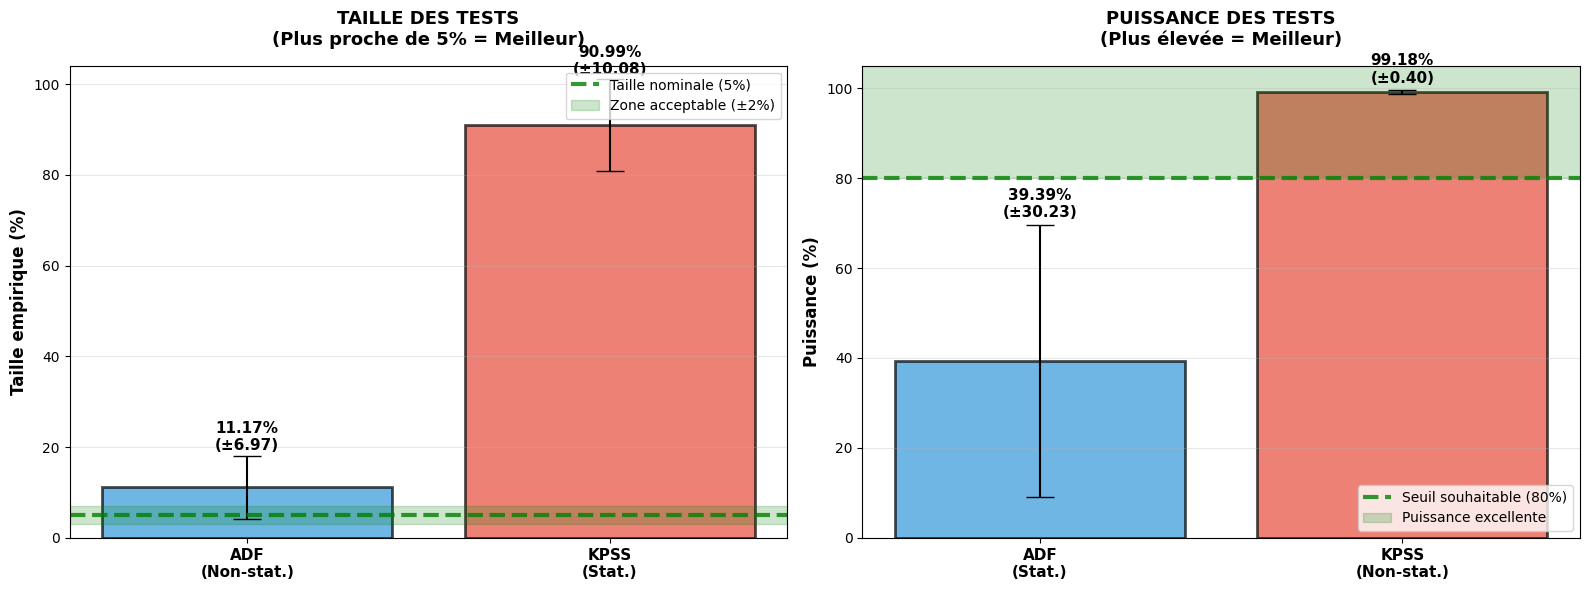


RÉSUMÉ QUANTITATIF

TAILLE DES TESTS:
  • ADF (sur non-stationnaires):  11.17% ± 6.97%
  • KPSS (sur stationnaires):     90.99% ± 10.08%

PUISSANCE DES TESTS:
  • ADF (sur stationnaires):      39.39% ± 30.23%
  • KPSS (sur non-stationnaires): 99.18% ± 0.40%



In [20]:
# Visualisation des leçons: Taille vs Puissance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Comparaison Taille observée vs Taille nominale
ax1 = axes[0]

categories = ['ADF\n(Non-stat.)', 'KPSS\n(Stat.)']
sizes_mean = [np.mean(adf_sizes), np.mean(kpss_sizes)]
sizes_std = [np.std(adf_sizes), np.std(kpss_sizes)]

x_pos = np.arange(len(categories))
bars = ax1.bar(x_pos, sizes_mean, yerr=sizes_std, capsize=10, 
               color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)

# Ligne de référence à 5%
ax1.axhline(y=5, color='green', linestyle='--', linewidth=3, label='Taille nominale (5%)', alpha=0.8)

# Zone acceptable (3-7%)
ax1.axhspan(3, 7, alpha=0.2, color='green', label='Zone acceptable (±2%)')

# Ajout des valeurs
for i, (bar, mean, std) in enumerate(zip(bars, sizes_mean, sizes_std)):
    ax1.text(bar.get_x() + bar.get_width()/2., mean + std + 0.5,
            f'{mean:.2f}%\n(±{std:.2f})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_ylabel('Taille empirique (%)', fontsize=12, fontweight='bold')
ax1.set_title('TAILLE DES TESTS\n(Plus proche de 5% = Meilleur)', 
             fontsize=13, fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(categories, fontsize=11, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(sizes_mean) + max(sizes_std) + 3)

# Graphique 2: Puissance des tests
ax2 = axes[1]

categories_power = ['ADF\n(Stat.)', 'KPSS\n(Non-stat.)']
powers_mean = [np.mean(adf_powers), np.mean(kpss_powers)]
powers_std = [np.std(adf_powers), np.std(kpss_powers)]

x_pos = np.arange(len(categories_power))
bars = ax2.bar(x_pos, powers_mean, yerr=powers_std, capsize=10,
               color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=2)

# Ligne de référence à 80%
ax2.axhline(y=80, color='green', linestyle='--', linewidth=3, 
           label='Seuil souhaitable (80%)', alpha=0.8)

# Zone excellente (>80%)
ax2.axhspan(80, 105, alpha=0.2, color='green', label='Puissance excellente')

# Ajout des valeurs
for i, (bar, mean, std) in enumerate(zip(bars, powers_mean, powers_std)):
    ax2.text(bar.get_x() + bar.get_width()/2., mean + std + 1,
            f'{mean:.2f}%\n(±{std:.2f})',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('Puissance (%)', fontsize=12, fontweight='bold')
ax2.set_title('PUISSANCE DES TESTS\n(Plus élevée = Meilleur)', 
             fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(categories_power, fontsize=11, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.show()

# Résumé numérique
print("\n" + "="*100)
print("RÉSUMÉ QUANTITATIF")
print("="*100)
print(f"\nTAILLE DES TESTS:")
print(f"  • ADF (sur non-stationnaires):  {np.mean(adf_sizes):5.2f}% ± {np.std(adf_sizes):.2f}%")
print(f"  • KPSS (sur stationnaires):     {np.mean(kpss_sizes):5.2f}% ± {np.std(kpss_sizes):.2f}%")
print(f"\nPUISSANCE DES TESTS:")
print(f"  • ADF (sur stationnaires):      {np.mean(adf_powers):5.2f}% ± {np.std(adf_powers):.2f}%")
print(f"  • KPSS (sur non-stationnaires): {np.mean(kpss_powers):5.2f}% ± {np.std(kpss_powers):.2f}%")
print("\n" + "="*100)

### Recommandations pratiques basées sur ces leçons

#### **1. Pour l'analyse empirique de séries temporelles:**

**a) Utiliser plusieurs tests:**
- Ne jamais se fier à un seul test de racine unitaire
- Combiner ADF et KPSS pour une conclusion robuste
- Considérer aussi d'autres tests (Phillips-Perron, DF-GLS, etc.)

**b) Considérer la persistance:**
- Pour des séries très persistantes (φ proche de 1):
  - Augmenter la taille d'échantillon si possible
  - Être prudent dans l'interprétation des résultats
  - Considérer la possibilité de ruptures structurelles

**c) Choisir la bonne spécification:**
- Inspecter visuellement la série avant de choisir entre "c" et "ct"
- Pour une série avec tendance claire → utiliser "ct"
- Pour une série sans tendance → utiliser "c"
- Une mauvaise spécification réduit la puissance

---

#### **2. Interprétation des résultats:**

**Scénario 1: Résultats concordants**
- ADF rejette H₀ ET KPSS ne rejette pas H₀ → **Série stationnaire** (haute confiance)
- ADF ne rejette pas H₀ ET KPSS rejette H₀ → **Série non-stationnaire** (haute confiance)

**Scénario 2: Résultats contradictoires**
- Peut indiquer une série dans la "zone grise" (très persistante)
- Nécessite une analyse plus approfondie:
  - Vérifier les ruptures structurelles
  - Augmenter la taille d'échantillon
  - Considérer des modèles fractionnellement intégrés

---

#### **3. Limitations à garder en esprit:**

**a) Taille d'échantillon:**
- n=200 est modéré pour les tests de racine unitaire
- La puissance augmente avec n, mais lentement
- Pour n petit, les tests peuvent manquer de puissance

**b) Distorsion de taille:**
- Les séries très persistantes causent une distorsion de taille
- Un taux de rejet > 5% ne signifie pas nécessairement un problème avec le test
- C'est une caractéristique inhérente aux tests de racine unitaire

**c) Hypothèses du modèle:**
- Les tests supposent des erreurs i.i.d.
- L'hétéroscédasticité ou l'autocorrélation affectent la performance
- Les ruptures structurelles peuvent biaiser les résultats vers la non-stationnarité

---

### Conclusion générale

Les simulations Monte Carlo révèlent les **défis fondamentaux** des tests de racine unitaire:

1. **Distorsion de taille:** Particulièrement problématique pour les processus très persistants (φ ≈ 1)

2. **Faible puissance près de la frontière:** Difficulté à distinguer φ=0.98 de φ=1.0 avec des échantillons modérés

3. **Trade-off taille-puissance:** Impossible d'optimiser simultanément les deux aspects

4. **Complémentarité nécessaire:** L'utilisation conjointe de tests avec hypothèses nulles opposées (ADF et KPSS) fournit une analyse plus complète et robuste

5. **Importance du contexte:** La spécification du test (c vs ct) et la compréhension du processus générateur de données sont cruciales pour une interprétation correcte

Ces leçons soulignent l'importance d'une **approche prudente et multifacette** dans l'analyse de la stationnarité des séries temporelles en économétrie.

## Question 1 - B

In [60]:
Market = pd.read_excel('ie_data.xls', sheet_name='Data', skiprows=7, usecols=(0,1,2,3))

Market = Market.dropna()

Market

,Date,P,D,E
0,1871.01,4.44,0.260000,0.400000
1,1871.02,4.5,0.260000,0.400000
2,1871.03,4.61,0.260000,0.400000
3,1871.04,4.74,0.260000,0.400000
4,1871.05,4.86,0.260000,0.400000
...,...,...,...,...
1825,2023.02,4079.684737,67.780000,174.363333
1826,2023.03,3968.55913,68.210000,175.170000
1827,2023.04,4121.467368,68.376667,177.170000
1828,2023.05,4146.173182,68.543333,179.170000


In [61]:
# Vérifier les colonnes disponibles dans Market
print("Colonnes dans Market:")
print(Market.columns.tolist())
print(f"\nAperçu des données:")
print(Market.head())
print(f"\nTypes de données:")
print(Market.dtypes)

# Convertir les colonnes en float si nécessaire
Market['P'] = Market['P'].astype(float)
Market['D'] = Market['D'].astype(float)
Market['E'] = Market['E'].astype(float)

Colonnes dans Market:
['Date', 'P', 'D', 'E']

Aperçu des données:
      Date     P     D    E
0  1871.01  4.44  0.26  0.4
1  1871.02   4.5  0.26  0.4
2  1871.03  4.61  0.26  0.4
3  1871.04  4.74  0.26  0.4
4  1871.05  4.86  0.26  0.4

Types de données:
Date    float64
P        object
D       float64
E       float64
dtype: object


In [62]:
# Sélectionner uniquement les colonnes P, D et E
Market_PDE = Market[['P', 'D', 'E']].copy()

# Transformer ces séries en logs
Market_log = np.log(Market_PDE)
Market_log.columns = ['log_P', 'log_D', 'log_E']